# Network Science - MDS - UDD 2022
## Introducción a Ciencia de Redes


#### Cristian Candia-Castro Vallejos, Ph.D.$^{1,2}$

- [1] Data Science Institute (IDS), Universidad del Desarrollo,Chile
- [2] Northwestern Institute on Complex Systems, Kellogg School of Management, Northwestern Unviersity, USA


Referencias:
1. http://networksciencebook.com/translations/en/resources/data.html
2. http://www-personal.umich.edu/~mejn/netdata/

# Comunidades
![title](img/intro.jpg)


# Detección de la comunidades en NetworkX
* Sorprendentemente, NetworkX (y muchas otras bibliotecas de redes) no tienen algoritmos de comunidades extensos
* Esto nos da una oportunidad para implementarlos desde cero.

# Importamos módulos requeridos

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as hierarchy

%matplotlib inline

# La red Zachary Karate Club
Esta red es tan ampliamente usada en el área, que existe una función especial en NetworkX solo para generar el grafo Zachary Karate Club.

Esta es una red social de un club de karate que fue estudiada por Wayne W. Zachary por un período de tres años desde 1970 hasta 1972. La red captura a 34 miembros de un club de karate y documenta los vínculos entre los miembros que interactuaban fuera del club. Durante el estudio, surgió un conflicto entre el administrador "John A" y el instructor "Mr. Hi" (seudónimos), lo que llevó a la división del club en dos. La mitad de los miembros formaron un nuevo club alrededor de Mr. Hi; los miembros de la otra parte encontraron un nuevo instructor o abandonaron el karate. Sobre la base de los datos recopilados, Zachary asignó correctamente a todos los miembros del club, excepto uno, a los grupos a los que realmente se unieron después de la división.

In [ ]:
G = nx.karate_club_graph()

Dibujemos la red con un algoritmo de diseño "forced-based" para obtener algo de intuición. Recuerda, este es un algoritmo estocástico por lo que tu diseño puede verse un poco diferente al mío.

In [ ]:
pos = nx.spring_layout(G)

In [ ]:
plt.figure(figsize=(12,8))
nx.draw_networkx(G, pos=pos, node_color='white', node_size=640)
limits = plt.axis('off')

Vamos a trazar las dos facciones post-división en diferentes colores.

In [ ]:
faction1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
faction2 = [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
communities = [faction1, faction2]
colors = ['red', 'cyan']

In [ ]:
plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos=pos)
for community, color in zip(communities, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=640)
nx.draw_networkx_labels(G, pos=pos)
_ = plt.axis('off')

* Debido a que los diseños force-based naturalmente agrupan subgrafos interconectados, en este caso casi podemos extraer visualmente las comunidades
* No obstante, no es perfecto debido a los límites intercomunidades
* Queremos una forma sistemática de encontrar comunidades, rojas y azules, sin tener que recurrir a la inspacción visual.

## Modularidad
La modularidad Q es una función de calidad que mide la calidad de una partición
concreta de una red en comunidades:
Se define como la diferencia entre el número de enlaces existentes en los grupos y el
número de enlaces esperado en una red aleatoria equivalente

![title](img/modu_eq.png)



# Implementando el algoritmo divisorio de Girvan y Newman


![title](img/gir_new.jpg)


* El algoritmo de Girvan-Newman:


Los algoritmos divisivos requieren una medida de centralidad que sea alta para los nodos que pertenecen a diferentes comunidades y baja para los pares de nodos en la misma comunidad. Dos medidas de uso frecuente pueden lograr esto:

* (a) El algoritmo jerárquico divisorio de Girvan y Newman usa el link betweenness (Imagen 9.11a del libro) como centralidad. En la figura, los pesos de los enlaces, asignados proporcionalmente a xij, indican que los enlaces que conectan diferentes comunidades tienen el xij más alto. De hecho, cada camino más corto entre estas comunidades debe atravesarlas.

* (b) - (d) La secuencia de imágenes ilustra cómo el algoritmo elimina uno por uno los tres enlaces xij más altos, dejando tres comunidades aisladas. Tenga en cuenta que el betweenness debe recalcularse después de cada eliminación de enlaces.

* (e) El dendrograma generado por el algoritmo Girvan-Newman. El corte en el nivel 3, que se muestra con una línea de puntos naranjos, reproduce las tres comunidades presentes en la red.

* (f) La función de modularidad, M, introducida en la SECCIÓN 9.4 (libro guía), nos ayuda a seleccionar el corte óptimo. Sus máximos coinciden con nuestra expectativa de que el mejor corte se encuentra en el nivel 3, como se muestra en (e).

In [ ]:
def girvan_newman(G):
    """ ejecuta el algoritmo de Girvan + Newman hasta la primera separación
         retorno: lista de componentes de G, lista de enlaces eliminados
    """
    
    # Vamos a eliminar enlaces, así que hacemos una copia del grafo original.
    G = G.copy()
    
    def find_best_edge(G0):
        """ obtener el enlace de G0 con mayor betweenness centrality"""
        eb = nx.edge_betweenness_centrality(G0)
        edges = eb.keys()
        return max(edges, key=lambda e: eb[e])

    removed_edges = []
    # Continua hasta separar el grafo.
    while nx.number_connected_components(G) == 1:
        u, v = find_best_edge(G)
        G.remove_edge(u, v)
        removed_edges.append((u, v))

    return list(nx.connected_components(G)), removed_edges

* Esta implementación se detiene en la primera separación de la red (en dos componentes)
* Por lo general, este algoritmo se aplica de forma recursiva en cada componente, lo que le permite obtener un dendrograma como antes

* Pros: intuitivo y fácil de implementar.
* Contras: lento, $\mathcal{O}(N ^ 3) $
* Como consecuencia, algoritmos más rápidos (pero más complicados) tienden a usarse en la práctica

### Veamos cómo se comparan los resultados de este algoritmo con las facciones reales del ZKC.

In [ ]:
communities, removed_edges = girvan_newman(G)
# Enlaces que NO fueron removidos por el algoritmo de GN
other_edges = set(G.edges()) - set(removed_edges)

In [ ]:
plt.figure(figsize=(12,8))
# plot enlaces, con los enlaces eliminados por el algoritmo en lineas discontinuas en lugar de lineas sólidas
nx.draw_networkx_edges(G, pos, edgelist=other_edges)
nx.draw_networkx_edges(G, pos, edgelist=removed_edges, style='dashed', edge_color='gray', width=3)
for community, color in zip(communities, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=640)
nx.draw_networkx_labels(G, pos=pos)
_ = plt.axis('off')

Bastante bien, ¿verdad? El primer nivel del dendrograma es suficiente para nuestros propósitos.

#  Clustering Jerárquico

* SciPy ya tiene herramientas para agrupar datos en función de una métrica de distancia
* Solo tenemos que darle la función de distancia apropiada.

Recordemos que la matriz de similitud se define como
$$ x_{ij}^0 = \frac{J_{ij}}{\textrm{min}(k_i, k_j) + 1 - \Theta(A_{ij})} $$
donde:
* $J_{ij}$ es el número de vecinos comunes de $i$ y $j$ mas 1 si $i$ esta conectado a $j$
* $k_i$, $k_j$ son los grados de $i$ y $j$
* $\Theta$ es la función Heaviside, que es cero para $A_{ij}\leq 0 $ y uno para $A_{ij}\geq 0 $.


![title](img/hier1.jpg)


* $ x_{ij}^0 = 1 $ si los nodos i y j tienen un enlace entre sí y tienen los mismos vecinos, como A y B en la Imagen 9.9a.
* $ x_{ij}^0 = 0 $ si i y j no tienen vecinos comunes, ni se vinculan entre sí, como A y E.
* Los miembros del mismo vecindario de red local denso tienen una alta superposición topológica, como los nodos H, I, J, K o E, F, G.







#### Superposición topológica


Una pequeña red que ilustra el cálculo de la superposición topológica $ x_{ij}^0 $. Para cada par de nodos i y j calculamos la superposición (9.7). El xij0 obtenido para cada par de nodos conectados se muestra en cada enlace. Tenga en cuenta que xij0 puede ser distinto de cero para los nodos que no se vinculan entre sí, pero tienen un vecino común. Por ejemplo, $ x_{ij} = 1/3$ para C y E.

#### Matriz de superposición topológica


La matriz de superposición topológica $ x_{ij}^0 $ para la red que se muestra en (a). Las filas y columnas de la matriz se reordenaron después de aplicar el agrupamiento promedio de enlaces, colocando uno junto al otro con los nodos con la mayor superposición topológica. Los colores denotan el grado de superposición topológica entre cada par de nodos, como se calcula en (a). Al cortar el dendrograma con la línea naranja, recupera los tres módulos integrados en la red. El dendograma indica que los módulos EFG y HIJK están más próximos entre sí que al módulo ABC.

In [ ]:
import itertools as it

def similarity_matrix(G):
    """ devuelve una matriz n x n que representa la matriz de similitud de G"""
    n = len(G)
    k = G.degree()
    A = nx.adjacency_matrix(G)
    
    # A^2 es el número de vecinos comunes, más A que da uno por estar conectado
    #J = A@A + A
    J=np.matmul(A.todense(),A.todense())+A.todense()
    #J=scp.sparse.csr_matrix(J)    
    X = np.zeros((n, n),dtype=float)
    for i, j in it.product(range(len(G.nodes())), repeat=2):
        X[i,j] = J[i,j]/(min(k[i], k[j]) + 1.0 - A[i, j])#con 1 en lugar de 1.0 da resultado entero (error)
    return X


In [ ]:
G = nx.karate_club_graph()
X = similarity_matrix(G)
X = X[np.isfinite(np.inf) == False]
X

In [ ]:
Z = hierarchy.linkage(X)
Z

In [ ]:
plt.figure(figsize=(16,8))
result = hierarchy.dendrogram(Z)

* Recuerde, el clustering jerárquico pertenecía al aprendizaje automático y otros campos antes de la ciencia de redes
* Como tal, no es fácil "cortar" los dendrogramas proporcionados por scipy y extraer las comunidades. La estructura de datos se diseñó para plotear, no para la detección de comunidades.


# Algoritmo Fast-Greedy



Como una mejora en la velocidad, también implementemos el algoritmo Fast-Greedy mencionado en el libro. No explicaré este código en detalle porque es más largo, pero recuerde que la estructura básica del algoritmo es:

Paso 1. Asigna cada nodo a una comunidad propia. Por eso empezamos con N comunidades.

Paso 2. Inspeccione cada par de comunidades conectadas por al menos un enlace y calcule la variación de modularidad obtenida si fusionamos estas dos comunidades.

Paso 3. Identifica los pares de comunidades para los cuales ΔM es el más grande y fusionelos. Tenga en cuenta que la modularidad de una partición en particular siempre se calcula a partir de la topología completa de la red.

Paso 4. Repita el paso 2 hasta que todos los nodos se fusionen en una sola comunidad.

Paso 5. Registre para cada paso y seleccione la partición para la cual la modularidad es máxima.

* Primero necesitamos una función de utilidad que proporcione la "matriz de comunidades" $ e_ {ij} $, donde $ e_ {ij} $ proporciona la fracción de enlaces que van desde de la comunidad $ i $ a la comunidad $ j $
* Esta matriz nos permite calcular rápidamente el aumento de modularidad de una posible fusión

In [6]:
def get_community_matrix(A, com):
    n = len(A)
    
    # número de comunidades
    nc = len(set(com))

    # Inicializar lista de matrices de adyacencia
    e = np.zeros((nc, nc))

    # Crea enlace y normaliza valores dividiendo por la suma de todos los enlaces (dependiente del tamaño de la red)
    m = 0
    for i in range(n):
        for j in range(n):
            if A[i, j] != 0:
                ic = com[i]
                jc = com[j]
                if ic == jc:
                    e[ic,ic] += A[i, j]
                else:
                    e[ic,jc] += 0.5*A[i,j]
                    e[jc,ic] = e[ic,jc]
                m += A[i,j]
    return e/m

Ahora el algoritmo principal:

In [7]:
def fast_greedy(G):
    import heapq

    L = G.size()
    #L = len(G.edges())
    for u, v in G.edges():
        #G.edge[u][v]['weight'] = 1.0/(2.0*L)
        G[u][v]['weight']=1.0/(2.0*L)
    for u in G:
        G.nodes[u]['weight'] = G.degree(u)/(2.0*L)
    
    # crear un nuevo grafo donde los nodos son comunidades (conjuntos de nodos)
    # se debe usar frozenset() ya que los nodos necesitan ser hashable
    H = nx.relabel_nodes(G, {node:frozenset((node,)) for node in G}, copy=True)
    heap = []
    heapq.heapify(heap)

    # peso del enlace i,j en H 
    def e(i, j):
        if H.has_edge(i, j):
            #return H.edge[i][j]['weight']
            return H[i][j]['weight']

        else:
            return 0
    
    # peso del nodo i en H 
    def a(i):
        if i in H:
            return H.nodes[i]['weight']
        else:
            return 0
        
    def get_best_pair():
        # retorna el par de nodos que maximiza el incrmento de Q en H
        while True:
            try:
                dQ, c1, c2 = heapq.heappop(heap)
            except IndexError:
                # Si no hay par, significa (habitualmente) que es grafor es disconexo
                return None, None, None
            if c1 in H and c2 in H:
                # el mejor par debe involucrar elementos que no han sido fusionados
                break
        # python's heap is a min-heap
        return -dQ, c1, c2
    
    def Q_change(c1, c2):
        return 2*(e(c1, c2) - a(c1)*a(c2)) 
    
    def add_to_heap(c1, c2):
        dQ = Q_change(c1, c2)
        # python's heap is a min-heap
        heapq.heappush(heap, (-dQ, c1, c2))
        
    def merge(c1, c2):
        comb = c1 | c2
        H.add_node(comb, weight=a(c1)+a(c2))
        #para los vecinos en el conjunto H.neighbors(c1) + H.neighbors(c2):
        for nbr in list(H.neighbors(c1)) + list(H.neighbors(c2)):
            
            # ignorar los enlaces internos en el "fusionador"
            if nbr == c1 or nbr == c2:
                continue
            # el peso total es la suma de los pesos antiguos
            H.add_edge(comb, nbr, weight=e(c1, nbr)+e(c2, nbr))
            add_to_heap(comb, nbr)
        H.remove_nodes_from([c1, c2])
        
    #for c1, c2 in H.edges_iter():
    for c1, c2 in list(dict(H.edges())):  
        add_to_heap(c1, c2)    
        
    L = H.size()
    #k = np.array(G.degree().values())
    k = np.array(list(dict(G.degree()).values()))
    Q = -sum(k**2)/(4.0*L**2)
    best_Q = Q
    best_partition = None
    
    while len(H) > 1:
        dQ, c1, c2 = get_best_pair()
        if c1 is None or c2 is None:
            break
        merge(c1, c2)
        Q += dQ 
        
        if Q > best_Q:
            best_Q = Q
            #best_partition = H.nodes()
            best_partition = list(dict(H.nodes()))

    return list(map(tuple, best_partition)), best_Q

In [28]:
G = nx.karate_club_graph()
best_partition, Q = fast_greedy(G)
print("La mejor partición encontrada consiste en {0} comunidad{1}:".format(
        len(best_partition), "" if len(best_partition) == 1 else "es"))
for c in best_partition:
    print(c)
print("La modularidad de esta particion es:", Q)

La mejor partición encontrada consiste en 3 comunidades:
(1, 2, 3, 7, 9, 12, 13, 17, 21)
(8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33)
(16, 0, 19, 4, 5, 6, 10, 11)
La modularidad de esta particion es: 0.38067061143984204


In [29]:
pos = nx.spring_layout(G)

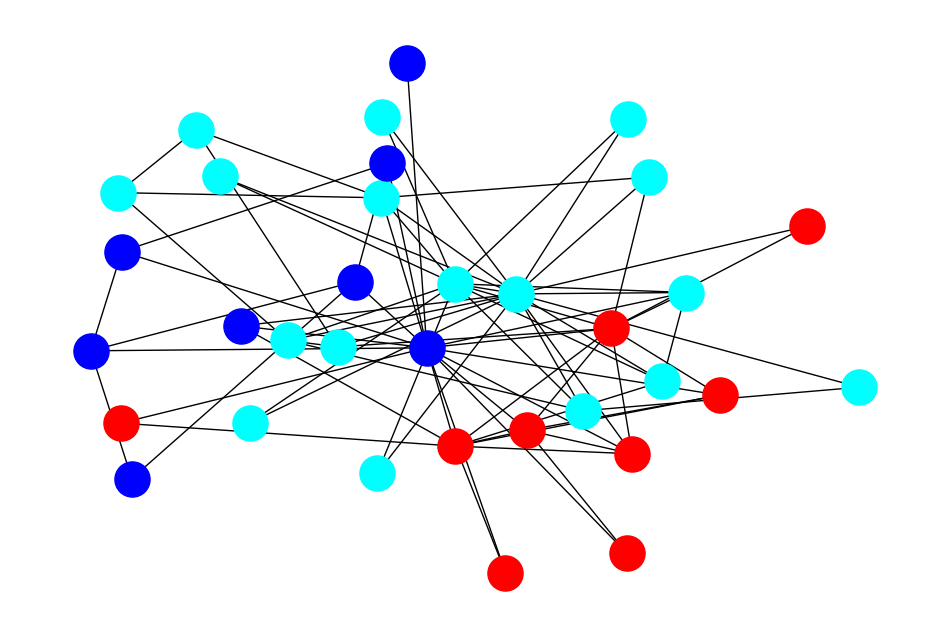

In [31]:
c1, c2 ,c3 = best_partition

colors = ['red', 'cyan','blue']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos)

for community, color in zip(best_partition, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=640)
#nx.draw_networkx_labels(G, pos=pos)
_ = plt.axis('off')

# Louvain


![title](img/louvain.png)


1) https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008 

In [ ]:
# conda install --yes --prefix {sys.prefix} python-louvain # 

In [245]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
import community
import numpy as np


%matplotlib inline

In [246]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G) # Layout para la red (coordenadas de los nodos y enlaces)

partition= community.best_partition(G)

print("La mejor partición encontrada consiste en {0} comunidad{1}:".format(
        len(set(partition.values())), "" if len(partition) == 1 else "es"))

Q=community.modularity(partition,G)
print("La modularidad de esta particion es:", Q)


# Creamos un diccionario de personajes y sus respectivas comunidades
d = {}
for character, par in partition.items():
    if par in d:
        d[par].append(character)
    else:
        d[par] = [character]
d

La mejor partición encontrada consiste en 4 comunidades:
La modularidad de esta particion es: 0.44490358126721763


{0: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 1: [4, 5, 6, 10, 16],
 3: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33],
 2: [23, 24, 25, 27, 28, 31]}

In [254]:
partition

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 1,
 5: 1,
 6: 1,
 7: 0,
 8: 3,
 9: 3,
 10: 1,
 11: 0,
 12: 0,
 13: 0,
 14: 3,
 15: 3,
 16: 1,
 17: 0,
 18: 3,
 19: 0,
 20: 3,
 21: 0,
 22: 3,
 23: 2,
 24: 2,
 25: 2,
 26: 3,
 27: 2,
 28: 2,
 29: 3,
 30: 3,
 31: 2,
 32: 3,
 33: 3}

In [ ]:
plt.figure(figsize=(10, 6))

size = (len(set(partition.values())))#Numero de comunidades

#plot, color nodes using community structure
count = 0
colors = [np.array(cm.jet(x)).reshape(1,-1) for x in np.linspace(0, 1, size)]#cm.jet es el mapa de colores https://www.programcreek.com/python/example/56498/matplotlib.cm.jet
for com in set(partition.values()): #para cada comunidad
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]#guarda los personajes que pertenecen a la comunidad `com`
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 100, node_color=colors[count])#plotea nodos con colors por comunidad
    count = count + 1# para iterar sobre los colores
nx.draw_networkx_edges(G, pos, alpha=0.2)#plotea enlaces
plt.show()

In [ ]:
# OTRO EJEMPLO

G = nx.random_graphs.powerlaw_cluster_graph(300, 1, .4)

#find modularity
part = community.best_partition(G)
mod = community.modularity(part,G)

#plot, color nodes using community structure
values = [part.get(node) for node in G.nodes()]
nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
plt.show()

# Modularidad: cuantificando la calidad de una partición
* Podemos evaluar la calidad de una posible división de una red en comunidades utilizando la modularidad, que se define como

$$Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right) \delta(c_i,c_j)$$
donde $m$ es el numero de enlaces, $A$ es la matriz de adyacencia de G, 
    $k_i$ es el grado de $i$ y $\delta(c_i,c_j)$ es 1 si $i$ y $j$ 
    pertenecen a la misma comunidad y 0 en otro caso.
    
* $Q$ es una cantidad escalar, que está entre $[-1, 1]$, asiciada con una particular red y a una particion particular de la misma red.


![title](img/mod1.jpg)


* Partición optima

La partición con modularidad máxima $M = 0,41$ coincide estrechamente con las dos comunidades distintas.

* Partición subóptima

Una partición con una modularidad subóptima pero positiva, $M = 0.22$, no identifica correctamente las comunidades presentes en la red.

* Comunidad unica

Si asignamos todos los nodos a la misma comunidad obtenemos $M = 0$, independientemente de la estructura de la red.

* Modularidad negativa

Si asignamos cada nodo a una comunidad diferente, la modularidad es negativa, obteniendo $M = -0.12$.

In [ ]:
def modularity(G, partition):
    m = G.number_of_edges()
    
    degree = G.degree()
    norm = 1.0/(2.0*m)
    
    Q = 0.0
    for c in partition:
        for u, v in it.product(c, repeat=2):
            w = 1 if G.has_edge(u, v) else 0
            #  cuenta doble self loop
            if u == v:
                w *= 2.0
            Q += w - degree[u] * degree[v] * norm
    return norm*Q

In [ ]:
# G sigue siendo la red ZKC de arriba
modularity(G, communities)

# TAREA 3

Tienen 2 semana para entregar esta tarea en ipython notebook en grupos de no más de 4 personas. 

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.cluster.hierarchy as hierarchy

%matplotlib inline

In [4]:
def fast_greedy(G):
    import heapq

    L = G.size()
    #L = len(G.edges())
    for u, v in G.edges():
        #G.edge[u][v]['weight'] = 1.0/(2.0*L)
        G[u][v]['weight']=1.0/(2.0*L)
    for u in G:
        G.nodes[u]['weight'] = G.degree(u)/(2.0*L)
    
    # crear un nuevo grafo donde los nodos son comunidades (conjuntos de nodos)
    # se debe usar frozenset() ya que los nodos necesitan ser hashable
    H = nx.relabel_nodes(G, {node:frozenset((node,)) for node in G}, copy=True)
    heap = []
    heapq.heapify(heap)

    # peso del enlace i,j en H 
    def e(i, j):
        if H.has_edge(i, j):
            #return H.edge[i][j]['weight']
            return H[i][j]['weight']

        else:
            return 0
    
    # peso del nodo i en H 
    def a(i):
        if i in H:
            return H.nodes[i]['weight']
        else:
            return 0
        
    def get_best_pair():
        # retorna el par de nodos que maximiza el incrmento de Q en H
        while True:
            try:
                dQ, c1, c2 = heapq.heappop(heap)
            except IndexError:
                # Si no hay par, significa (habitualmente) que es grafor es disconexo
                return None, None, None
            if c1 in H and c2 in H:
                # el mejor par debe involucrar elementos que no han sido fusionados
                break
        # python's heap is a min-heap
        return -dQ, c1, c2
    
    def Q_change(c1, c2):
        return 2*(e(c1, c2) - a(c1)*a(c2)) 
    
    def add_to_heap(c1, c2):
        dQ = Q_change(c1, c2)
        # python's heap is a min-heap
        heapq.heappush(heap, (-dQ, c1, c2))
        
    def merge(c1, c2):
        comb = c1 | c2
        H.add_node(comb, weight=a(c1)+a(c2))
        #para los vecinos en el conjunto H.neighbors(c1) + H.neighbors(c2):
        for nbr in list(H.neighbors(c1)) + list(H.neighbors(c2)):
            
            # ignorar los enlaces internos en el "fusionador"
            if nbr == c1 or nbr == c2:
                continue
            # el peso total es la suma de los pesos antiguos
            H.add_edge(comb, nbr, weight=e(c1, nbr)+e(c2, nbr))
            add_to_heap(comb, nbr)
        H.remove_nodes_from([c1, c2])
        
    #for c1, c2 in H.edges_iter():
    for c1, c2 in list(dict(H.edges())):  
        add_to_heap(c1, c2)    
        
    L = H.size()
    #k = np.array(G.degree().values())
    k = np.array(list(dict(G.degree()).values()))
    Q = -sum(k**2)/(4.0*L**2)
    best_Q = Q
    best_partition = None
    
    while len(H) > 1:
        dQ, c1, c2 = get_best_pair()
        if c1 is None or c2 is None:
            break
        merge(c1, c2)
        Q += dQ 
        
        if Q > best_Q:
            best_Q = Q
            #best_partition = H.nodes()
            best_partition = list(dict(H.nodes()))

    return list(map(tuple, best_partition)), best_Q

# Ejercicio 1 - Detección de comunidades en una red grande.
***Instricciones:***
1. Usa la funcioón `read_gml` para cargar la red en`group1.gml`.
2. Calcule la partición óptima de la red de acuerdo con el algoritmo fast greedy.
3. ¿Cuáles son los tamaños de las dos comunidades más grandes en relación con el tamaño de la red? ¿Cuántos nodos quedan en otras comunidades?
4. Siguiendo los ejemplos de la red de karate, dibuje la red con las dos mayores comunidades en dos colores diferentes como se muestra arriba. Puedes colorear los nodos restantes en gris. Comenta sobre lo que ves. Le sugiero que desactive las etiquetas de nodo y reduzca el tamaño del nodo a `node_size=20` para mayor claridad, ya que la red es grande. Use `pos=nx.kamada_kawai_layout(G)`
5. Mire el archivo GML sin procesar y vea si puede adivinar qué es la red.
6. ¿Qué sospecha que representan los nodos "sobrantes"? (de nuevo, el archivo GML probablemente te pueda dar una pista si los buscas)

#### 1.- Usa la funcioón read_gml para cargar la red engroup1.gml

In [114]:
# TIPS ejercicio 1
Gt = nx.read_gml("./group1.gml")# Lee archivo
C, Q = fast_greedy(Gt) # Comunidades y modularidad (ver función arriba)
c1, c2 = C[:2] #Las dos comunidades mas grandes c1 y c2
others = set.union(*map(set, C[2:])) # todo el resto de los nodos que pertenecen a otras comunidades (distintas de c1 y c2)

#### 2.-Calcule la partición óptima de la red de acuerdo con el algoritmo fast greedy.

In [115]:
best_partition, Q = fast_greedy(Gt)
print("La mejor partición encontrada consiste en {0} comunidad{1}:".format(
        len(best_partition), "" if len(best_partition) == 1 else "es"))
#for c in best_partition:
    #print(c)
print("La modularidad de esta particion es:", Q)

La mejor partición encontrada consiste en 10 comunidades:
La modularidad de esta particion es: 0.42675796548512124


#### 3.- ¿Cuáles son los tamaños de las dos comunidades más grandes en relación con el tamaño de la red? ¿Cuántos nodos quedan en otras comunidades?

In [116]:
import pandas as pd

i = 0
com = {}
com_len = {}
for c in best_partition:
    com[i] = c
    i= i+1

for i in range(len(com)):
    com_len[i] = len(com[i])
    
df_com_len = pd.DataFrame.from_dict(com_len, orient='index', columns=['Tamaño']).sort_values('Tamaño',ascending=False)
    
print(f'Las 2 comunidades mas grandes son:\n')    
print(df_com_len.iloc[0:2])
print(f'Relación Red más grande: {int(df_com_len.iloc[0:1].sum()/df_com_len.iloc[0:10].sum()*100)}%')
print(f'Relación Segunda Red más grande: {int(df_com_len.iloc[1:2].sum()/df_com_len.iloc[0:10].sum()*100)}%')
print(f'\n\nLos nodos en las redes restantes son:\n')
print(df_com_len.iloc[2:10].sum())

Las 2 comunidades mas grandes son:

   Tamaño
8     634
9     544
Relación Red más grande: 51%
Relación Segunda Red más grande: 44%


Los nodos en las redes restantes son:

Tamaño    44
dtype: int64


#### 4.- Siguiendo los ejemplos de la red de karate, dibuje la red con las dos mayores comunidades en dos colores diferentes como se muestra arriba. Puedes colorear los nodos restantes en gris. Comenta sobre lo que ves. Le sugiero que desactive las etiquetas de nodo y reduzca el tamaño del nodo a node_size=20 para mayor claridad, ya que la red es grande. Use pos=nx.kamada_kawai_layout(G)

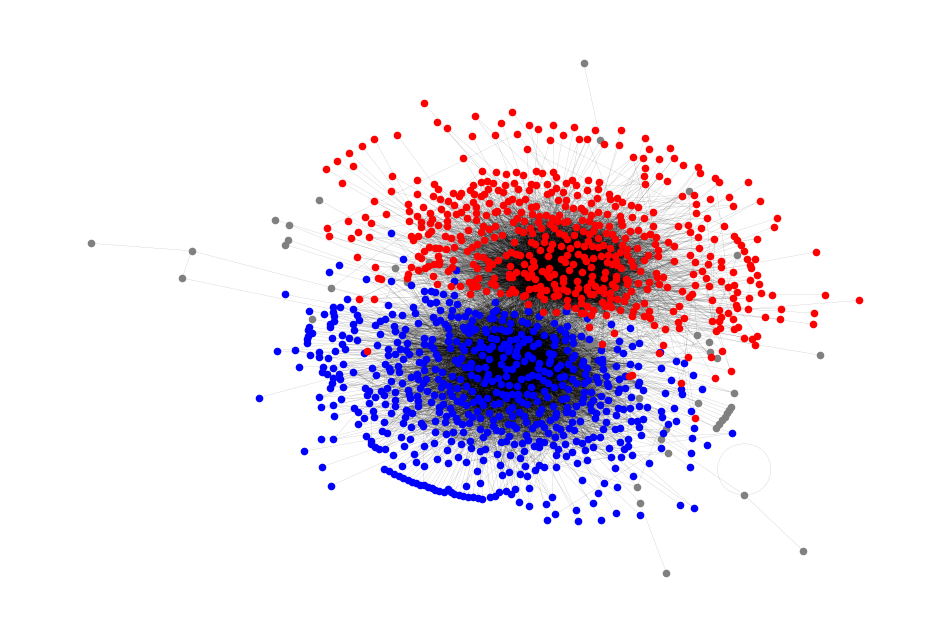

In [118]:
pos = nx.kamada_kawai_layout(Gt)

c1, c2 ,c3, c4, c5, c6, c7, c8, c9, c10 = best_partition

colors = ['gray', 'gray','gray','gray', 'gray','gray','gray', 'gray','blue','red']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(Gt, pos, width=0.05)

for community, color in zip(best_partition, colors):
    nx.draw_networkx_nodes(Gt, pos=pos, nodelist=community, node_color=color, node_size=20)
#nx.draw_networkx_labels(Gt, pos=pos)
_ = plt.axis('off')

#### 5.- Mire el archivo GML sin procesar y vea si puede adivinar qué es la red.

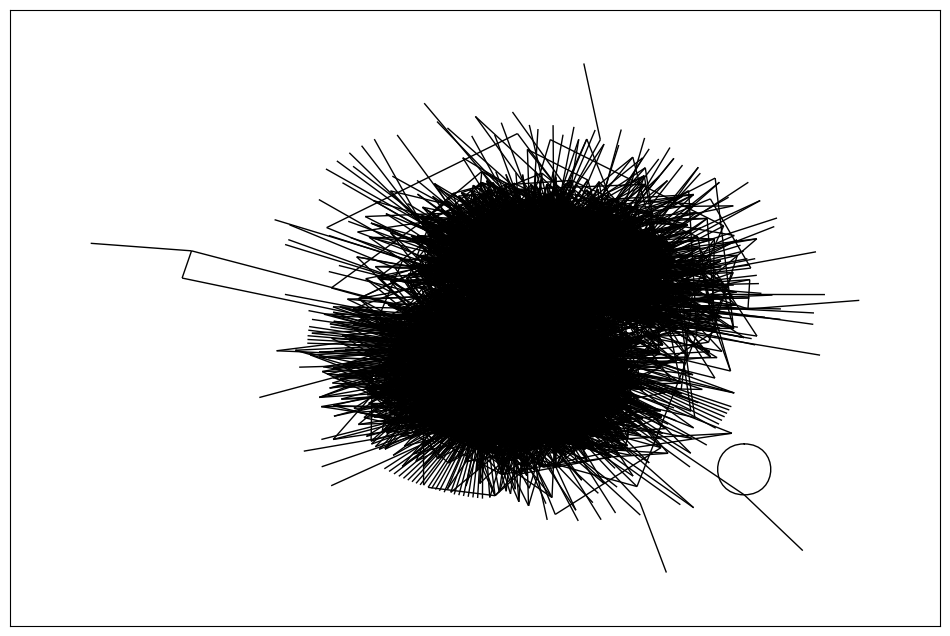

In [131]:
plt.figure(figsize=(12,8))
nx.draw_networkx_edges(Gt, pos)

In [137]:
edge_df = nx.to_pandas_edgelist(Gt) 

nodelist = list(Gt.nodes(data=True)) 
node_df = pd.DataFrame(nodelist, columns=['Node', 'name_attribute']) 
node_df

,Node,name_attribute
0,100monkeystyping.com,"{'value': 0, 'source': 'Blogarama', 'weight': ..."
1,12thharmonic.com/wordpress,"{'value': 0, 'source': 'BlogCatalog', 'weight'..."
2,750volts.blogspot.com,"{'value': 0, 'source': 'Blogarama', 'weight': ..."
3,95theses.blogspot.com,"{'value': 0, 'source': 'Blogarama', 'weight': ..."
4,abbadabbaduo.blogspot.com,"{'value': 0, 'source': 'Blogarama,LeftyDirecto..."
...,...,...
1217,youngconservative.blogspot.com,"{'value': 1, 'source': 'Blogarama', 'weight': ..."
1218,zebrax.blogs.com,"{'value': 1, 'source': 'BlogCatalog', 'weight'..."
1219,zeke01.blogspot.com,"{'value': 1, 'source': 'Blogarama,BlogCatalog'..."
1220,zeke01.typepad.com,"{'value': 1, 'source': 'Blogarama', 'weight': ..."


#### 6.- ¿Qué sospecha que representan los nodos "sobrantes"? (de nuevo, el archivo GML probablemente te pueda dar una pista si los buscas)

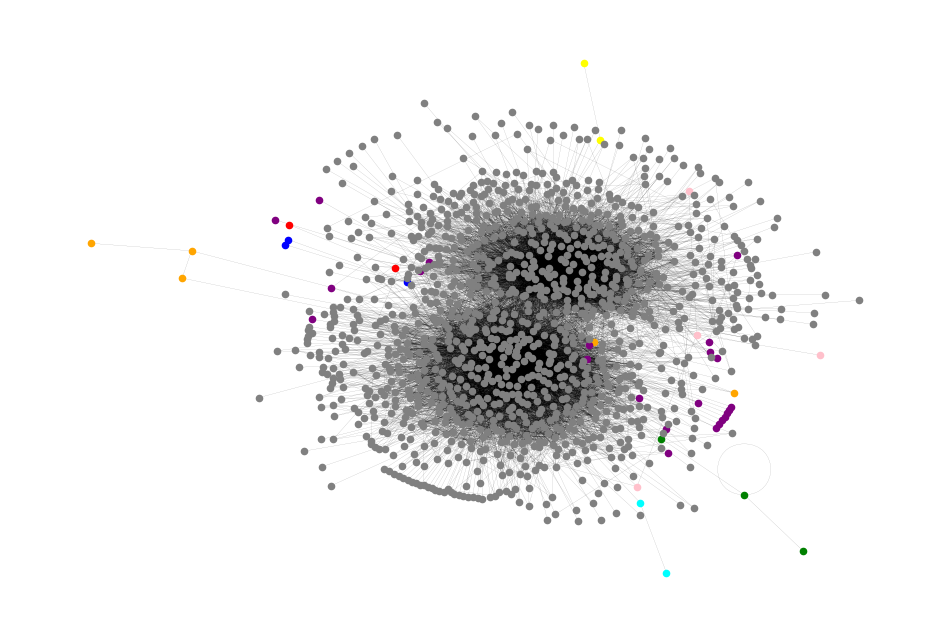

In [135]:
pos = nx.kamada_kawai_layout(Gt)

c1, c2 ,c3, c4, c5, c6, c7, c8, c9, c10 = best_partition

colors = ['cyan', 'yellow','red','blue', 'green','pink','orange', 'purple', 'gray', 'gray']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(Gt, pos, width=0.05)

for community, color in zip(best_partition, colors):
    nx.draw_networkx_nodes(Gt, pos=pos, nodelist=community, node_color=color, node_size=20)
#nx.draw_networkx_labels(Gt, pos=pos)
_ = plt.axis('off')

###### Respuesta

Se trata de comunidades que involucran nodos con un solo enlace y donde en general los nodos presentan un bajo grado de centralidad.

# Ejercicio 2 - Modularidad
***Instrucciones:***
1. Lea la documentación de la función NetworkX `nx.random_partition_graph` (https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.random_partition_graph.html)
2. Explique lo que hace este modelo.
3. Úselo para generar una red de cuatro comunidades, cada una con 25 nodos. Use `p_in = 0.5` y `p_out=0.01`.
4. Dibuja la red. Colorea los cuatro grupos de nodos usando los colores. `["red", "blue", "yellow", "green"]` siguiendo el ejemplo del club de karate de arriba.
5. ¿Cual esperas que sea la partición de esta red con la mayor modularidad? Ingrese manualmente y calcule su modularidad. En este modelo, los nodos son números enteros generados en orden por comunidad "natural", por ejemplo. 0, ..., 24 son la comunidad natural 1. Sugerencia: puede usar `list (range (i, j))` para obtener una lista de enteros entre `i` y` j-1` (inclusive).
6. Cree una partición que debería tener una modularidad que sea exactamente cero. Calcula su modularidad para verificar. Explique en términos de la ecuación de arriba.
7. Diseñe una partición que tenga modularidad negativa. Calcúlela. Expliquela en términos de la ecuación anterior.

#### 1.- Lea la documentación de la función NetworkX nx.random_partition_graph (https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.random_partition_graph.html)

![title](img/random_partition_graph.jpg)

#### 2.- Explique lo que hace este modelo

###### Respuesta:

Permite generar una red aleatoria  en base a una cantidad definida de comunidade, cada una con una cantidad definida de nodos. También es posible definir la probabilidad de enlases entre nodos dentro de una misma comunidad y la probabilidad de enlases entre comunidades.

#### 3.- Úselo para generar una red de cuatro comunidades, cada una con 25 nodos. Use p_in = 0.5 y p_out=0.01.

In [275]:
G = nx.random_partition_graph([25,25,25, 25],0.5,0.01)
partition = G.graph['partition']

#### 4.- Dibuja la red. Colorea los cuatro grupos de nodos usando los colores. ["red", "blue", "yellow", "green"] siguiendo el ejemplo del club de karate de arriba.

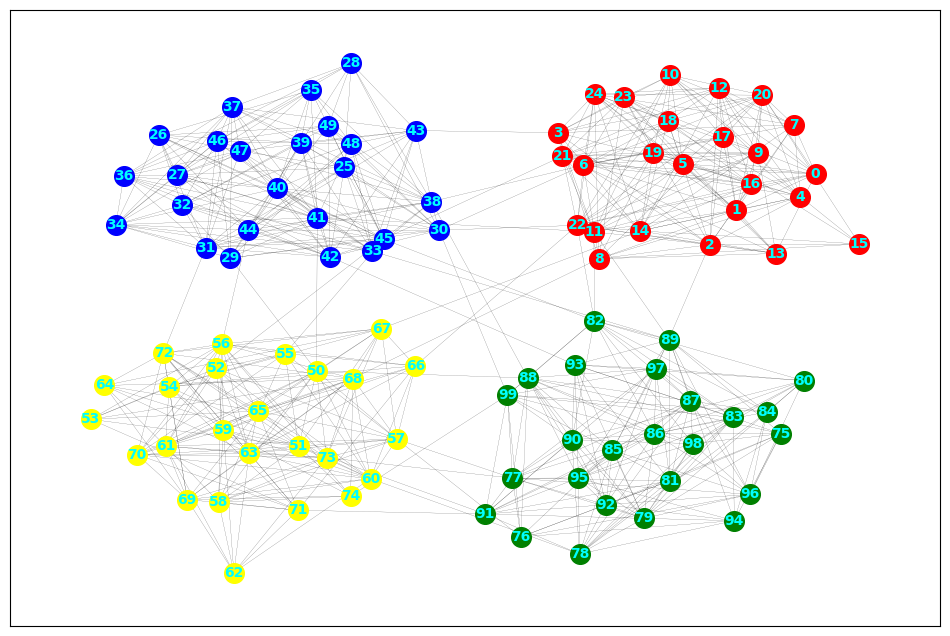

In [202]:
pos = nx.kamada_kawai_layout(G)

c1,c2,c3,c4 = partition
colors = ['red', 'blue', 'yellow', 'green']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos, width=0.1)

nx.draw_networkx_labels(G, pos=pos, font_color='cyan', font_size= 10, font_weight='black')

for community, color in zip(partition, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=200)



#### 5.- ¿Cual esperas que sea la partición de esta red con la mayor modularidad?  Ingrese manualmente y calcule su modularidad. En este modelo, los nodos son números enteros generados en orden por comunidad "natural", por ejemplo. 0, ..., 24 son la comunidad natural 1. Sugerencia: puede usar list (range (i, j)) para obtener una lista de enteros entre i yj-1 (inclusive).

In [285]:
c1 = list(range(0,50))
c2 = list(range(50,100))
partition = [c1, c2]
import networkx.algorithms.community as nx_comm
print(f'La mayor modularidad esperada es: {nx_comm.modularity(G, communities=partition)} ')

La mayor modularidad esperada es: 0.4598208411911757 


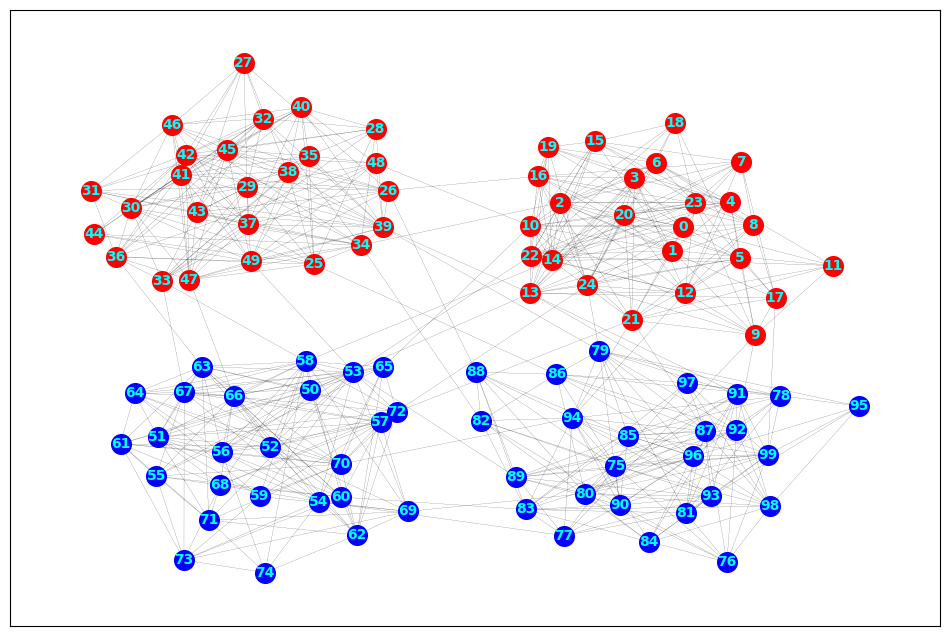

In [278]:
pos = nx.kamada_kawai_layout(G)

c1,c2 = partition
colors = ['red', 'blue']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos, width=0.1)

nx.draw_networkx_labels(G, pos=pos, font_color='cyan', font_size= 10, font_weight='black')

for community, color in zip(partition, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=200)

#### 6.- Cree una partición que debería tener una modularidad que sea exactamente cero. Calcula su modularidad para verificar. Explique en términos de la ecuación de arriba.

In [287]:
c1 = list(range(0,100))
c2 = list(range(100,100))
partition = [c1, c2]
import networkx.algorithms.community as nx_comm
print(f'La modularidad esperada es: {nx_comm.modularity(G, communities=partition)} ')

La modularidad esperada es: 0.0 


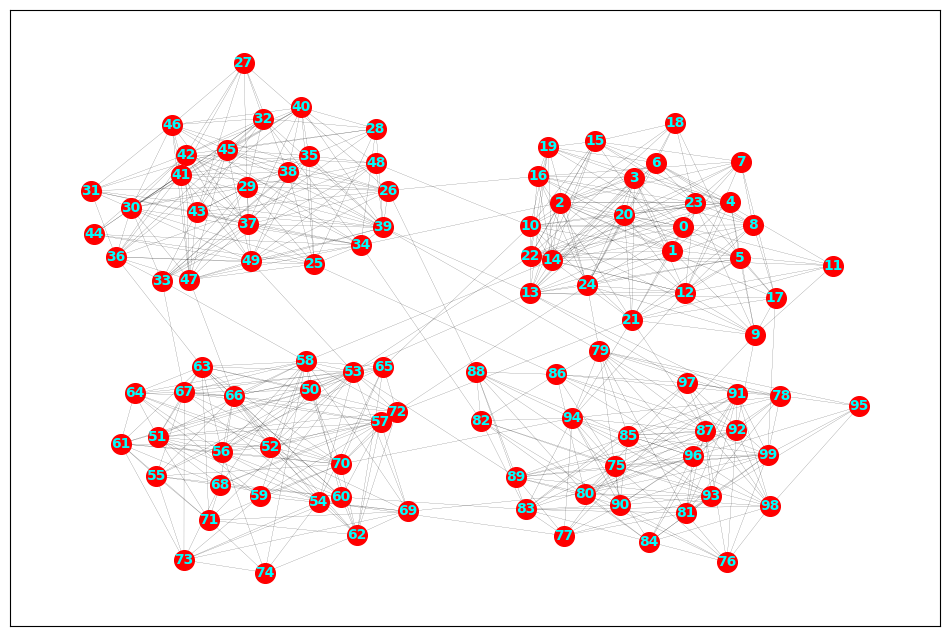

In [288]:
pos = nx.kamada_kawai_layout(G)

c1,c2 = partition
colors = ['red', 'blue']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos, width=0.1)

nx.draw_networkx_labels(G, pos=pos, font_color='cyan', font_size= 10, font_weight='black')

for community, color in zip(partition, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=200)

#### 7.- Diseñe una partición que tenga modularidad negativa. Calcúlela. Expliquela en términos de la ecuación anterior.

In [295]:
c1 = list(range(0,98))
c2 = list(range(98,99))
c3 = list(range(99,100))

partition = [c1, c2, c3]
import networkx.algorithms.community as nx_comm
print(f'La modularidad esperada es: {nx_comm.modularity(G, communities=partition)} ')

La modularidad esperada es: -0.0007524341037674057 


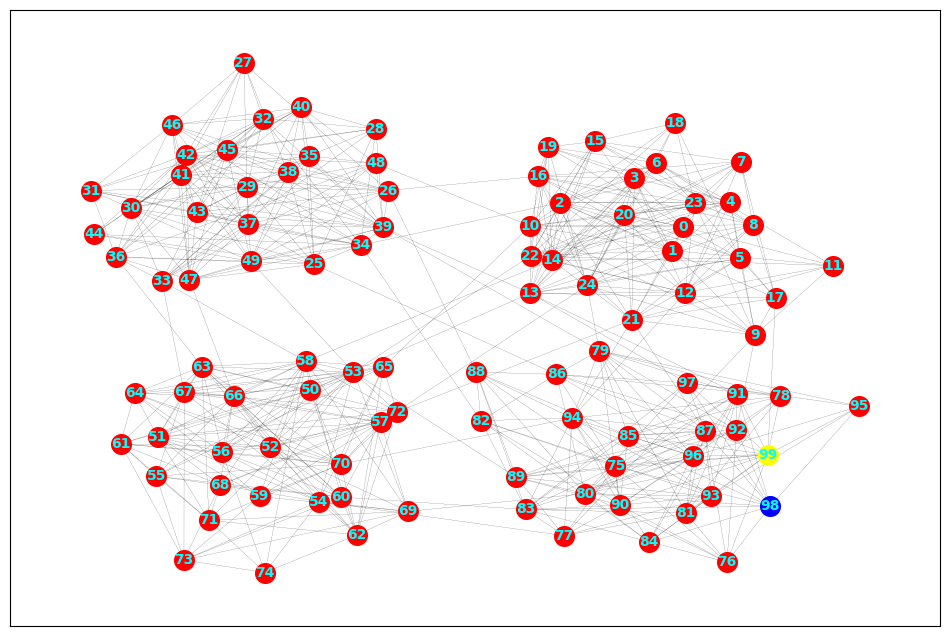

In [296]:
pos = nx.kamada_kawai_layout(G)

c1,c2,c3 = partition
colors = ['red', 'blue', 'yellow']

plt.figure(figsize=(12,8))
nx.draw_networkx_edges(G, pos, width=0.1)

nx.draw_networkx_labels(G, pos=pos, font_color='cyan', font_size= 10, font_weight='black')

for community, color in zip(partition, colors):
    nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=200)

# Ejercicio 3 - Modularidad en Redes Aleatorias
***Instrucciones:***
1. Reproducirá parte de la Figura 1b en el documento analizado adjunto, para S = 1000 nodos (usan S en lugar de N para el tamaño de la red en ese paper).

<img src="img/amaral.png" alt="Drawing" style="width: 400px;"/>


http://www.uvm.edu/pdodds/teaching/courses/2009-08UVM-300/docs/others/everything/guimera2004b.pdf


2. Escriba la función `er_max_modularity (k_avg)` que hace lo siguiente 10 veces: 

    a) genera un grafo aleatorio de ER con un grado promedio de k_avg, calcula la mejor partición de ese grafo usando el algoritmo fast greedy, luego registra su modularidad (construye una lista). La función debe devolver dos cosas: el promedio y la desviación estándar de los 10 valores de modularidad. P.ej. si ha llamado a su lista `Q`, devuelva ` np.mean (Q), np.std (Q) `
    
3. Genere una lista de 6 grados promedio espaciados logarítmicamente entre 2 y 10, llámela `K`.
4. Para cada grado promedio en 'K', use su función para calcular la media y la desviación estándar de la modularidad para un conjunto de redes ER con esa conectividad. Asígnelos a los arrays `mu` y` sigma`. 
5. Haz una gráfica de barras de error de tus resultados usando la desviación estándar de la modularidad como los "bigotes". Es decir, `plt.errorbar (K, mu, yerr = sigma)`. Configure la escala x para que sea logarítmica con `plt.gca (). Set_xscale ('log')`